* **APOD**: **A**ssess, **P**arallelize, **O**ptimize, **D**eploy é um Design Pattern muito importante da programação CUDA. É um design iterativo, o qual os desenvolvedores CUDA podem aplicar o seus melhoramentos incrementais para acelerar suas aplicações e colocá-las em produção.

[*CUDA Best Practices Guide*](http://docs.nvidia.com/cuda/cuda-c-best-practices-guide/index.html#memory-optimizations)

# Nsys profile

* Nesse notebook, aprenderemos sobre:
    * Como utilizar a ferramenta ```nsys```: O sistema Nsight ou ```nsys``` é uma ferramenta por comando de linha para medir qualitativamente a performance da sua aplicação para identificar possíveis oportunidades para optimização.
    * O conceito de memória unificada    

* O nsys é bem fácil de utilizar, basicamente, você pega o código que você compilou com nvcc e gerou um executável e passa o caminho deste executável para o ```nsys```, que trará informações para você sobre sua aplicação e a memória unificada.

``` !nvcc -o single-thread-vector-add module2/01-vector-add.cu -run ```

``` !nsys profile --stats=true ./single-thread-vector-add```

* Quando utilizamos a flag ``` --stats=true ``` é para que o nsys traga algumas medidas estatísticas resumidas pra gente, dentre eles diferentes níveis da aplicação:
- Operating System Runtime Summary (`osrt_sum`)
- **CUDA API Summary (`cuda_api_sum`)**
- **CUDA Kernel Summary (`cuda_gpu_kern_sum`)**
- **CUDA Memory Time Operation Summary (`cuda_gpu_mem_time_sum`)**
- **CUDA Memory Size Operation Summary (`cuda_gpu_mem_size_sum`)**

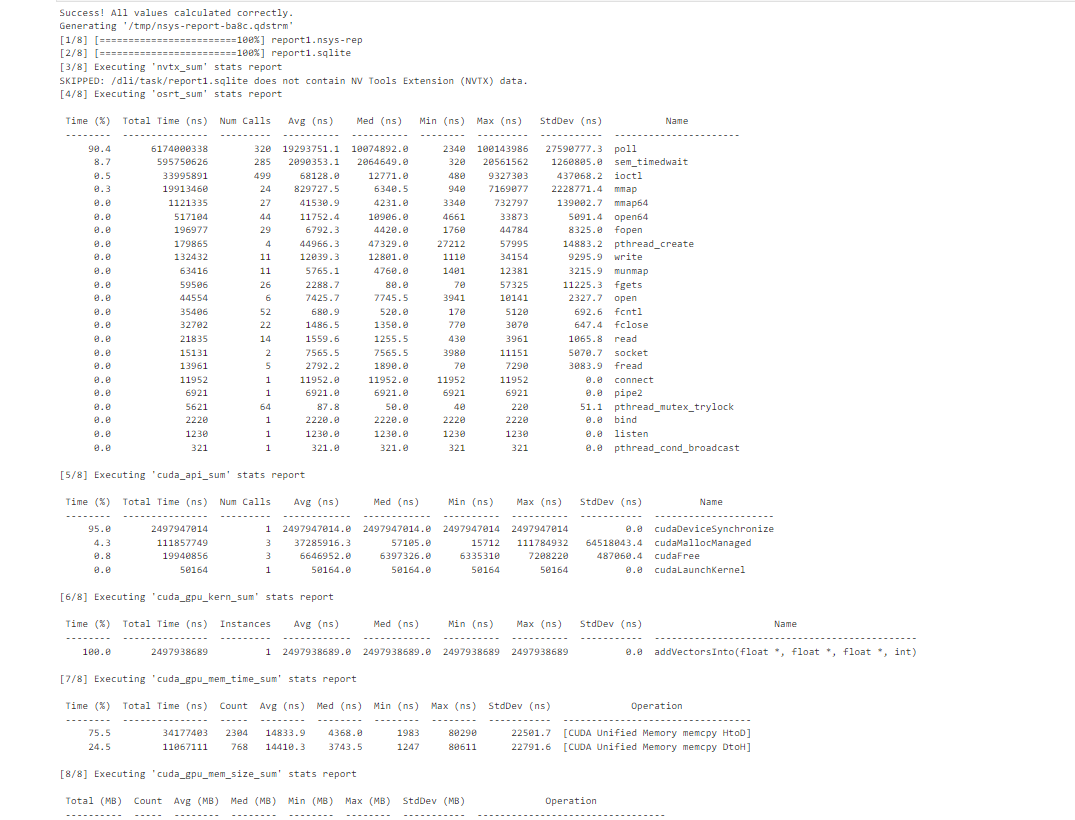

* Por padrão um ``` nsys profile ``` não sobrescreverá um outro ``` nsys profile ```, isto pq cada profile gera dois arquivos, um nsys e outro sqlite, se quisermos fazer outra análise, devemos utilizar a flag ``` -f ``` para permitir a sobrescrita. 

O interessante de profilar é alterar as configurações de execução de um kernel várias vezes e ver qual configuração para o seu kernel trouxe um tempo menor em ``` cuda_gpu_kern_sum ```

# Streaming Multiprocessor

* As GPUs da NVIDIA possuem unidades funcionais chamadas de Streaming Multiprocessor ou SM's. Os blocos de threads anteriormente vistos são escalados para trabalhar em uma SM. Dependendo do número de SM's em uma GPU e os requerimentos de um bloco, mais de um bloco pode trabalhar por SM. As dimensões do Grid, isto é, a quantidade de blocos em um Grid ser múltiplo da quantidade de SM's é uma coisa boa, pq assim teríamos a utilização completa de todos os SM's da GPU. É importante dizer também que um bloco é a menor unidade possível para trabalhar em um SM, isto é, a quantidade de blocos que trabalha em uma SM é discreta.

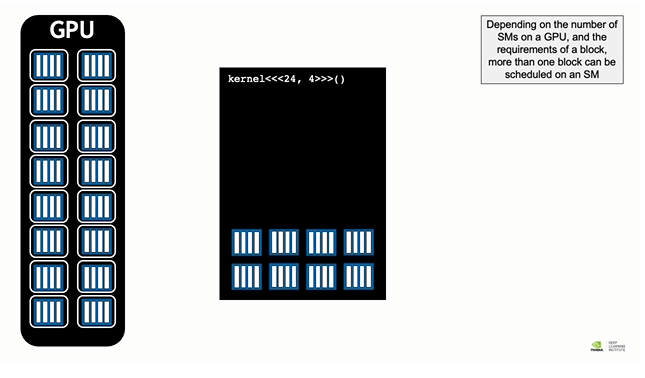

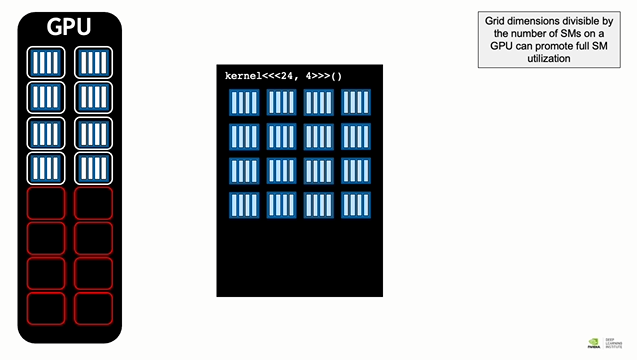

Na imagem acima, temos um kernel de 24 blocos que contêm 4 threads por bloco. Como nossa GPU possui apenas 16 SM's, então teríamos que escalar primeiro 16 blocos do kernel e depois os 8 restantes. Por isso, é interssante que a quantidade de blocos de um Grid seja um divisor da quantidade de SM's da GPU ou se possível igual.

# Quantidade de SM's em uma GPU e outras informações da GPU

* Beleza, se devemos utilizar a quantidade de blocos em um Grid igual a quantidade de SM's em uma GPU ou um múltiplo desta quantidade, como sei a quantidade de SM's na minha GPU?

```cpp
int deviceId;
cudaGetDevice(&deviceId);                  // `deviceId` now points to the id of the currently active GPU.

cudaDeviceProp props;
cudaGetDeviceProperties(&props, deviceId); // `props` now has many useful properties about
                                           // the active GPU device.
```

* Exemplo sobre em: module2/device-properties.cu

* Desta forma ao implementar um kernel, podemos perguntar pra nossa GPU antes de decidir a quantidade de blocos no Grid, a quantidade de SM's que ela tem para fazermos a utilização desses SM's da melhor forma possível.

* Exemplo sobre em: module2/add-vectors-intelligent.cu

### Tempo sem utilizar uma quantidade de blocos múltipla da qtd. de SM'S

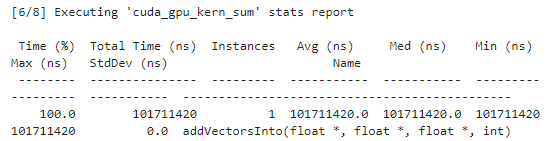

### Tempo utilizando uma quantidade de blocos múltipla da qtd. de SM'S

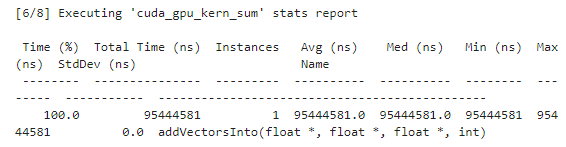

# Memória Unificada

* Quando no notebook passado, utilizávamos ```cudaMallocManaged``` estávamos alocando memória que poderia ser utilizada tanto pela CPU, quanto pela GPU. Este é o conceito de memória unificada, que aprofundaremos a seguir.

* Inicialmente, quando alocamos a memória unificada, a partir da função ``` cudaMallocManaged ```, este dado é alocado em um local não identificado. Isto é, ela não está alocada na CPU, nem na GPU, ela está em outro local.
* Quando chamamos uma função, seja uma função na CPU ou um kernel na GPU, que utiliza esse dado pela primeira vez depois da alocação, ocorrerá um processo que chamamos de **Page Fault**, a função chamada procurará este dado na CPU, caso seja uma função da CPU e procurará na GPU, caso seja um kernel da GPU, mas não encontrará o endereço deste dado, já que ele não está nem na CPU e nem na GPU. Depois de não encontrar, isto é, ocorrer o **Page Fault** o dado começará a fazer a migração do lugar (não identificado) que ele estava para a CPU ou para a GPU, a depender da função que chamou ele.
* O **Page Fault** ocorre não só na primeira chamada após o cudaMallocManaged(), mas também em situação em que primeiro existe uma chamada da CPU e logo depois da GPU, ou vice-versa, isto é quando existe a troca de unidades em que este dado não é residente. Por exemplo, se chamamos uma função da CPU após o cudaMallocManaged() ocorrerá o **Page Fault** do dado de um lugar não identificado para CPU, depois do dado estar na CPU e ser utilizado por esta função, suponhamos também que chamemos um kernel da GPU, que também provocará um **Page Fault** já que o dado estava na CPU e tentou ser acessado pela GPU, levando um tempo até ser levado para GPU e depois acessado por este kernel.
* Se nós sabemos que precisamos acessar um dado, a partir de um lugar específico, seja da CPU ou da GPU, que o dado não seja residente, podemos manualmente colocá-lo lá antes de chamar as funções, de modo a evitar o **Page Fault**, que resulta nesta transição do dado de uma região para outra de forma automática, através da função: ``` cudaMemPrefetchAsync(cpu) ``` ou ```  cudaMemPrefetchAsync(GPU) ```
* Este processo é importante, porque prevenimos que o dado seja transportado de forma automática e além disso, os dados são levados de pouco em pouco para outra região da memória. Através da função ```cudaMemPrefetch``` podemos levar grandes quantidades de dados já para uma região, sem ter que ocorrer esste Page Faulting.
* Também existe uma função para checar se este dado já está no local que queremos utilizar, a partir de check()

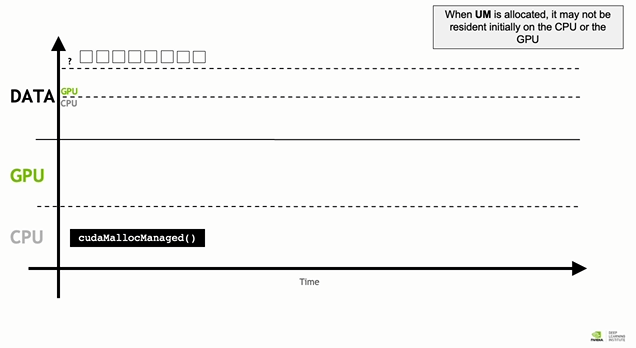

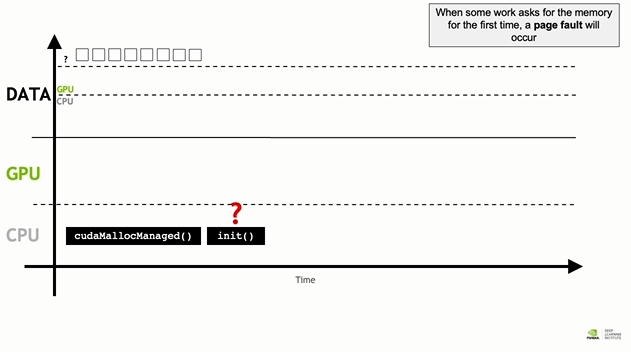

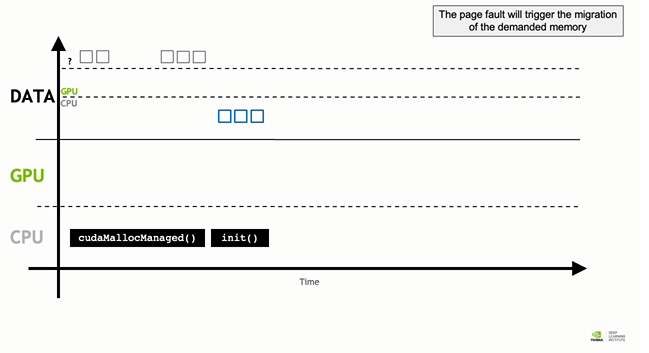

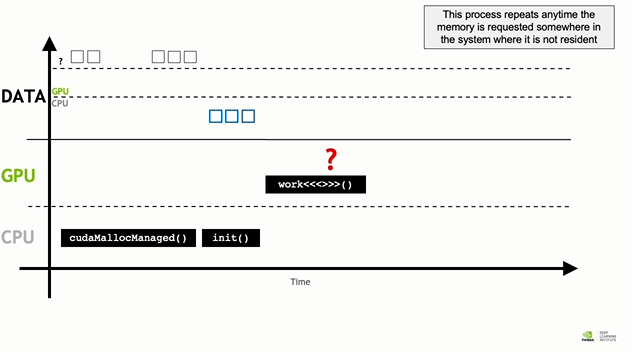

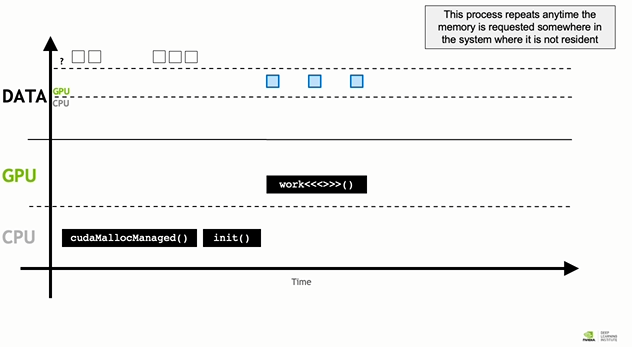

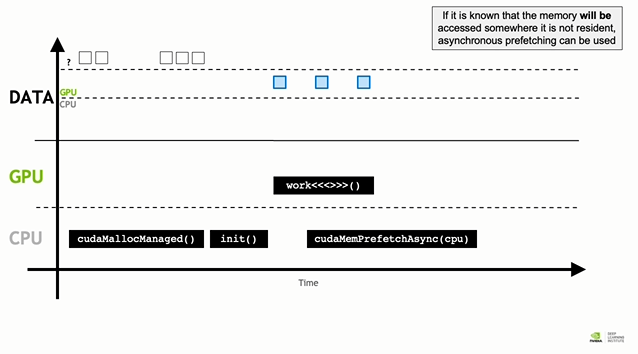

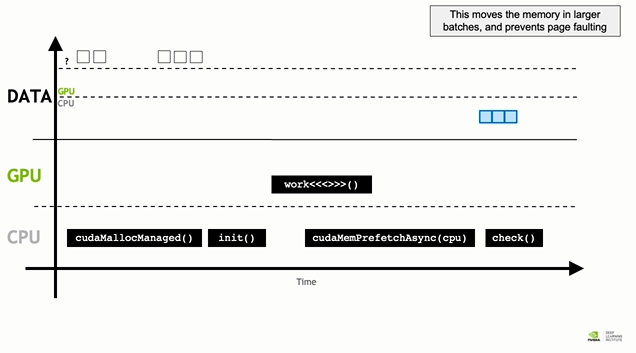

* Se quisermos investigar se um código CUDA está sofrendo com **Page Fault** devemos avaliar no profiling estas partes:
- **CUDA Memory Time Operation Summary (`cuda_gpu_mem_time_sum`)**
- **CUDA Memory Size Operation Summary (`cuda_gpu_mem_size_sum`)**

* HtoD significa Host to Device (transf. dados da CPU para GPU)
* DtoH significa Device to Host (transf. dados da GPU para CPU)

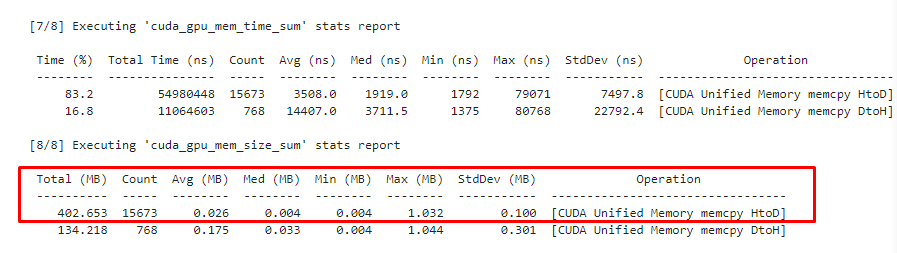

* Neste caso certamente está ocorrendo **Page Fault** já que existem muitas e PEQUENAS transferências da CPU para GPU

## Asynchronous Memory Prefetching

* Para evitar o **Page Fault** e esta transferência automática, que transfere lentamente por pegar poucos dados e fazer muitas transferências, utilizamos o ``` cudaMemPrefetchAsync ``` que transfere os dados de forma manual 

```cpp
int deviceId;
cudaGetDevice(&deviceId);                                         // The ID of the currently active GPU device.

cudaMemPrefetchAsync(pointerToSomeUMData, size, deviceId);        // Prefetch to GPU device.
cudaMemPrefetchAsync(pointerToSomeUMData, size, cudaCpuDeviceId); // Prefetch to host. `cudaCpuDeviceId` is a
                                                                  // built-in CUDA variable.
```

# Profilando o exercício final - SAXPY

!nvcc -o saxpy module2/saxpy.cu -run

!nsys profile --stats=true ./saxpy

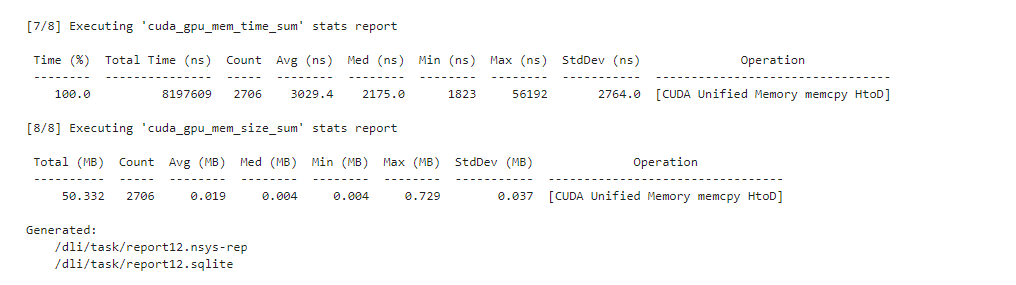

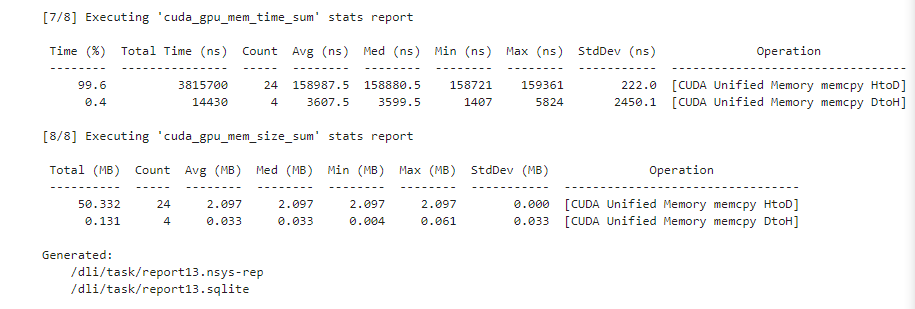

* Redução do tempo
* Redução significativa da quantidade de transferências e aumento do tamanho dos dados nestas transferências, em *cuda_gpu_mem_size_sum*, prevenindo o **Page Faulting**